In [1]:
import pImpactR as impact
import numpy as np
from copy import deepcopy as copy

In [2]:
nturn = 1

In [3]:
beam,lattice = impact.elegant2impact('NSLS2.lat',impact.util.Me,3.0e9,-1.0,min_sext_L=0.02)
ke = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency

lattice.insert(0,impact.getElem('loop'))
lattice[0].turns=nturn

write = impact.getElem('write_raw_ptcl')
write.file_id = 1111
write.format_id = 2
write.turn = nturn
lattice.append(write)

elegant ksext of length 0.2 found. Converting to 10 drift-kick-drift thin element
elegant ksext of length 0.2 found. Converting to 10 drift-kick-drift thin element
elegant ksext of length 0.2 found. Converting to 10 drift-kick-drift thin element
elegant ksext of length 0.2 found. Converting to 10 drift-kick-drift thin element
elegant ksext of length 0.25 found. Converting to 13 drift-kick-drift thin element
elegant ksext of length 0.2 found. Converting to 10 drift-kick-drift thin element
elegant ksext of length 0.2 found. Converting to 10 drift-kick-drift thin element
elegant ksext of length 0.2 found. Converting to 10 drift-kick-drift thin element
elegant ksext of length 0.2 found. Converting to 10 drift-kick-drift thin element
elegant ksext of length 0.2 found. Converting to 10 drift-kick-drift thin element
elegant ksext of length 0.2 found. Converting to 10 drift-kick-drift thin element
elegant ksext of length 0.2 found. Converting to 10 drift-kick-drift thin element
elegant ksext o

In [4]:
B = [(0.0,-1)]
S = [(0.0,-1)]
Q = [(0.0,-1)]
L = 0
for item in lattice:
    if item.type == 'dipole':
        B.append((L,-1))
        B.append((L,1))
        B.append((L+item.length,1))
        B.append((L+item.length,-1))
    if item.type == 'quad':
        Q.append((L,-1))
        Q.append((L,1))
        Q.append((L+item.length,1))
        Q.append((L+item.length,-1))
    if 'length' in item.keys():
        if item.length == 0.01 or item.length == 0.02:
            S.append((L,-1))
            S.append((L,1))
            S.append((L+item.length,1))
            S.append((L+item.length,-1))
        L = L+item.length
B=np.array(B)
S=np.array(S)
Q=np.array(Q)

In [5]:
beam.n_particles=1
# beam.distribution.distribution_type = 'Waterbag'
# beam.distribution.offsetx = 0.01
# beam.distribution.offsety = 0.01

In [6]:
# for item in lattice:
#     if item.type == 'multipole_thin':
#         item.KL_sext=0.0

In [7]:
import h5py
f = h5py.File('Kilean_FB.h5', 'r')

bw=f.get('bw').value
fw=f.get('fw').value
s=f.get('s').value

f = h5py.File('Kilean_FB_linear.h5', 'r')

bwL=f.get('bw').value
fwL=f.get('fw').value
sL=f.get('s').value

/home/kileanhwang/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [8]:
q_m = beam.multi_charge.q_m[0]
pData = np.zeros([1,9])
pData[0,:4]=fw[0]
pData[0,6]=q_m
pData[0,-1]=1

In [9]:
L = 0
for item in lattice:
    if 'length' in item.keys():
        L = L+item.length
L

52.79720000000009

In [10]:
impact.writeParticleData(pData,ke,mass,freq)
impact.writeInputFile(beam,lattice)

# Forward

In [11]:
impact.run(beam)

0

In [12]:
!mv test.in test.forward.in

In [13]:
beam.distribution


 distribution_type: 'ReadFile'
              betx: 0.0 [m]
              alfx: 0.0
             emitx: 0.0 [m-rad]
              bety: 0.0 [m]
              alfy: 0.0
             emity: 0.0 [m-rad]
              betz: 0.0 [degree/MeV]
              alfz: 0.0
             emitz: 0.0 [degree-MeV]
            scalex: 1.0 [1.0]
           scalepx: 1.0 [1.0]
           offsetx: 0.0 [m]
          offsetpx: 0.0 [rad]
            scaley: 1.0 [1.0]
           scalepy: 1.0 [1.0]
           offsety: 0.0 [m]
          offsetpy: 0.0 [rad]
            scalez: 1.0 [1.0]
           scalepz: 1.0 [1.0]
           offsetz: 0.0 [degree]
          offsetpz: 0.0 [MeV]
              mode: 'twiss'

In [14]:
fort24F = np.loadtxt('fort.24')
fort25F = np.loadtxt('fort.25')

In [15]:
!rm fort.24 fort.25

# Backward

In [16]:
beam.distribution.distribution_type = 'ReadFile_binary'
beam.distribution.file_id = 1111

In [17]:
latticeB = copy(lattice[::-1])
latticeB.insert(0,copy(lattice[0]))
latticeB.pop()


  type: 'loop'
 turns: 1

In [18]:
latticeB.pop(1)


          type: 'write_raw_ptcl'
       file_id: 1111
     format_id: 2
          turn: 1
 sample_period: 1

In [19]:
latticeB[0].turns = nturn
latticeB.append(write)

for i in range(len(latticeB)):
    if 'length' in latticeB[i].keys():
        latticeB[i].length = -latticeB[i].length
        
    if latticeB[i].type == 'dipole':
        
        latticeB[i].bending_angle            =-latticeB[i].bending_angle
        latticeB[i].fringe_field_integration =-latticeB[i].fringe_field_integration
        
        exitAng  = latticeB[i].exit_angle
        enterAng = latticeB[i].entrance_angle
        latticeB[i].exit_angle     = -enterAng
        latticeB[i].entrance_angle = -exitAng
        
    if 'KL_sext' in latticeB[i]:
        latticeB[i].KL_sext = -latticeB[i].KL_sext

        
impact.writeInputFile(beam,latticeB)
impact.run(beam)

0

In [20]:
!mv test.in test.backward.in

In [21]:
L = 0
for item in latticeB:
    if 'length' in item.keys():
#         if item.length>0:
#             print(item)
        L = L+item.length
L

-52.79720000000009

In [22]:
fort24B = np.loadtxt('fort.24')#[::-1,:]
fort25B = np.loadtxt('fort.25')#[::-1,:]

In [23]:
fort24B[:,0]=fort24B[:,0]-fort24B[-1,0]
fort25B[:,0]=fort25B[:,0]-fort25B[-1,0]

In [24]:
fort24B[:,:]=fort24B[::-1,:]
fort25B[:,:]=fort25B[::-1,:]

In [25]:
sprev = 0
indexF = []
for i,snext in enumerate(fort24F[:,0]):
    if snext!=sprev:
        indexF.append(i)
    sprev = snext

sprev = 0 
indexB = []
for i,snext in enumerate(fort24B[:,0]):
    if snext!=sprev:
        indexB.append(i)
    sprev = snext

In [26]:
fort24F = fort24F[indexF,:]
fort25F = fort25F[indexF,:]
fort24B = fort24B[indexB,:]
fort25B = fort25B[indexB,:]

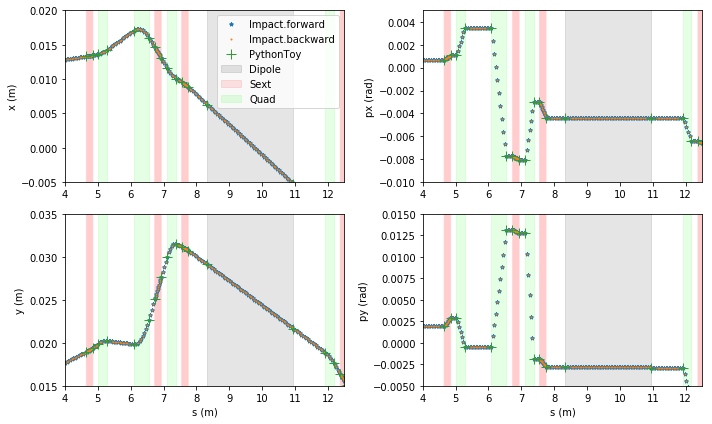

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.subplot(2,2,1)
plt.plot(fort24F[:,0],fort24F[:,1],'*',markersize=4.0)
plt.plot(fort24B[:,0],fort24B[:,1],'o',markersize=1.0)
plt.plot(s,fw[:,0],'+',markersize=10.0)
plt.fill_between(B[:,0],B[:,1],y2=-1,color=(0,0,0),alpha=0.1)
plt.fill_between(S[:,0],S[:,1],y2=-1,color=(1,0,0),alpha=0.1)
plt.fill_between(Q[:,0],Q[:,1],y2=-1,color=(0,1,0),alpha=0.1)
plt.ylim(-0.005,0.02)
plt.xlim(4,12.5)
# plt.xlabel('s (m)')
plt.ylabel('x (m)')
plt.legend(['Impact.forward','Impact.backward','PythonToy','Dipole','Sext','Quad'])
plt.subplot(2,2,2)
plt.plot(fort24F[:,0],fort24F[:,3],'*',markersize=4.0)
plt.plot(fort24B[:,0],fort24B[:,3],'o',markersize=1.0)
plt.plot(s,fw[:,1],'+',markersize=10.0)
plt.fill_between(B[:,0],B[:,1],y2=-1,color=(0,0,0),alpha=0.1)
plt.fill_between(S[:,0],S[:,1],y2=-1,color=(1,0,0),alpha=0.1)
plt.fill_between(Q[:,0],Q[:,1],y2=-1,color=(0,1,0),alpha=0.1)
plt.ylim(-0.01,0.005)
plt.xlim(4,12.5)
# plt.xlabel('s (m)')
plt.ylabel('px (rad)')
# plt.legend(['Impact','PythonToy','Dipole','Sext','Quad'])
plt.subplot(2,2,3)
plt.plot(fort25F[:,0],fort25F[:,1],'*',markersize=4.0)
plt.plot(fort25B[:,0],fort25B[:,1],'o',markersize=1.0)
plt.plot(s,fw[:,2],'+',markersize=10.0)
plt.fill_between(B[:,0],B[:,1],y2=-1,color=(0,0,0),alpha=0.1)
plt.fill_between(S[:,0],S[:,1],y2=-1,color=(1,0,0),alpha=0.1)
plt.fill_between(Q[:,0],Q[:,1],y2=-1,color=(0,1,0),alpha=0.1)
plt.ylim(0.015,0.035)
plt.xlim(4,12.5)
plt.xlabel('s (m)')
plt.ylabel('y (m)')
# plt.legend(['Impact','PythonToy','Dipole','Sext','Quad'])
plt.subplot(2,2,4)
plt.plot(fort25F[:,0],fort25F[:,3],'*',markersize=4.0)
plt.plot(fort25B[:,0],fort25B[:,3],'o',markersize=1.0)
plt.plot(s,fw[:,3],'+',markersize=10.0)
plt.fill_between(B[:,0],B[:,1],y2=-1,color=(0,0,0),alpha=0.1)
plt.fill_between(S[:,0],S[:,1],y2=-1,color=(1,0,0),alpha=0.1)
plt.fill_between(Q[:,0],Q[:,1],y2=-1,color=(0,1,0),alpha=0.1)
plt.ylim(-0.005,0.015)
plt.xlim(4,12.5)
plt.xlabel('s (m)')
plt.ylabel('py (rad)')
# plt.legend(['Impact','PythonToy','Dipole','Sext','Quad'])
plt.tight_layout()
plt.savefig('comparision.yesSext.png',dpi=180)

In [28]:
xdiff = fort24F[:,1]-fort24B[:,1]
pxdiff = fort24F[:,3]-fort24B[:,3]
ydiff = fort25F[:,1]-fort25B[:,1]
pydiff = fort25F[:,3]-fort25B[:,3]

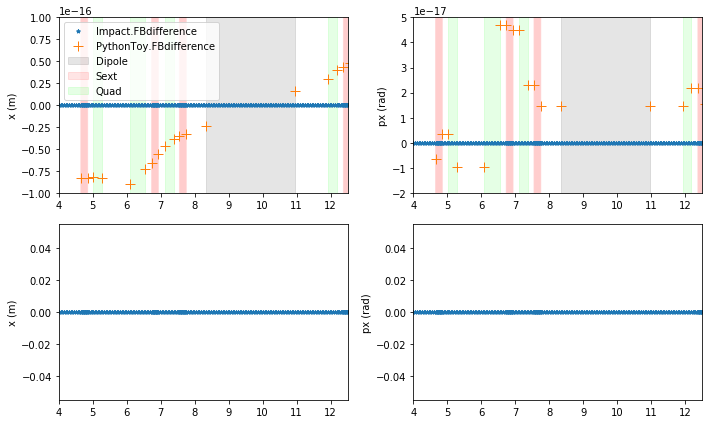

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.subplot(2,2,1)
plt.plot(fort24F[:,0],xdiff,'*',markersize=4.0)
plt.plot(s,fw[:,0]-bw[::-1,0],'+',markersize=10.0)
plt.fill_between(B[:,0],B[:,1],y2=-1,color=(0,0,0),alpha=0.1)
plt.fill_between(S[:,0],S[:,1],y2=-1,color=(1,0,0),alpha=0.1)
plt.fill_between(Q[:,0],Q[:,1],y2=-1,color=(0,1,0),alpha=0.1)
plt.ylim(-1e-16,1e-16)
plt.xlim(4,12.5)
# plt.xlabel('s (m)')
plt.ylabel('x (m)')
plt.legend(['Impact.FBdifference','PythonToy.FBdifference','Dipole','Sext','Quad'])
            
plt.subplot(2,2,2)
plt.plot(fort24F[:,0],pxdiff,'*',markersize=4.0)
plt.plot(s,fw[:,1]-bw[::-1,1],'+',markersize=10.0)
plt.fill_between(B[:,0],B[:,1],y2=-1,color=(0,0,0),alpha=0.1)
plt.fill_between(S[:,0],S[:,1],y2=-1,color=(1,0,0),alpha=0.1)
plt.fill_between(Q[:,0],Q[:,1],y2=-1,color=(0,1,0),alpha=0.1)
plt.ylim(-2e-17,5e-17)
plt.xlim(4,12.5)
# plt.xlabel('s (m)')
plt.ylabel('px (rad)')
# plt.legend(['Impact','PythonToy','Dipole','Sext','Quad'])
            
plt.subplot(2,2,3)
plt.plot(fort24F[:,0],xdiff,'*',markersize=4.0)
# plt.fill_between(B[:,0],B[:,1],y2=-1,color=(0,0,0),alpha=0.1)
# plt.fill_between(S[:,0],S[:,1],y2=-1,color=(1,0,0),alpha=0.1)
# plt.fill_between(Q[:,0],Q[:,1],y2=-1,color=(0,1,0),alpha=0.1)
# plt.ylim(-9e-16,9e-16)
plt.xlim(4,12.5)
# plt.xlabel('s (m)')
plt.ylabel('x (m)')
# plt.legend(['Impact.FBdifference','PythonToy.FBdifference','Dipole','Sext','Quad'])
            
plt.subplot(2,2,4)
plt.plot(fort24F[:,0],pxdiff,'*',markersize=4.0)
# plt.fill_between(B[:,0],B[:,1],y2=-1,color=(0,0,0),alpha=0.1)
# plt.fill_between(S[:,0],S[:,1],y2=-1,color=(1,0,0),alpha=0.1)
# plt.fill_between(Q[:,0],Q[:,1],y2=-1,color=(0,1,0),alpha=0.1)
# plt.ylim(-5e-17,5e-17)
plt.xlim(4,12.5)
# plt.xlabel('s (m)')
plt.ylabel('px (rad)')
# plt.legend(['Impact','PythonToy','Dipole','Sext','Quad'])
plt.tight_layout()
plt.savefig('comparision.diff.yesSext.png',dpi=180)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.subplot(2,2,1)
plt.plot(fort24[:,0],fort24[:,1],'+',markersize=4.0)
plt.plot(s,fwL[:,0],'*',markersize=4.0)
plt.fill_between(B[:,0],B[:,1],y2=-1,color=(0,0,0),alpha=0.1)
plt.fill_between(S[:,0],S[:,1],y2=-1,color=(1,0,0),alpha=0.1)
plt.fill_between(Q[:,0],Q[:,1],y2=-1,color=(0,1,0),alpha=0.1)
plt.ylim(-0.005,0.02)
plt.xlim(4,12.5)
# plt.xlabel('s (m)')
plt.ylabel('x (m)')
plt.legend(['Impact','PythonToy','Dipole','Sext','Quad'])
plt.subplot(2,2,2)
plt.plot(fort24[:,0],fort24[:,3],'+',markersize=4.0)
plt.plot(s,fwL[:,1],'*',markersize=4.0)
plt.fill_between(B[:,0],B[:,1],y2=-1,color=(0,0,0),alpha=0.1)
plt.fill_between(S[:,0],S[:,1],y2=-1,color=(1,0,0),alpha=0.1)
plt.fill_between(Q[:,0],Q[:,1],y2=-1,color=(0,1,0),alpha=0.1)
plt.ylim(-0.01,0.005)
plt.xlim(4,12.5)
# plt.xlabel('s (m)')
plt.ylabel('px (rad)')
# plt.legend(['Impact','PythonToy','Dipole','Sext','Quad'])
plt.subplot(2,2,3)
plt.plot(fort24[:,0],fort25[:,1],'+',markersize=4.0)
plt.plot(s,fwL[:,2],'*',markersize=4.0)
plt.fill_between(B[:,0],B[:,1],y2=-1,color=(0,0,0),alpha=0.1)
plt.fill_between(S[:,0],S[:,1],y2=-1,color=(1,0,0),alpha=0.1)
plt.fill_between(Q[:,0],Q[:,1],y2=-1,color=(0,1,0),alpha=0.1)
plt.ylim(0.015,0.03)
plt.xlim(4,12.5)
plt.xlabel('s (m)')
plt.ylabel('y (m)')
# plt.legend(['Impact','PythonToy','Dipole','Sext','Quad'])
plt.subplot(2,2,4)
plt.plot(fort24[:,0],fort25[:,3],'+',markersize=4.0)
plt.plot(s,fwL[:,3],'*',markersize=4.0)
plt.fill_between(B[:,0],B[:,1],y2=-1,color=(0,0,0),alpha=0.1)
plt.fill_between(S[:,0],S[:,1],y2=-1,color=(1,0,0),alpha=0.1)
plt.fill_between(Q[:,0],Q[:,1],y2=-1,color=(0,1,0),alpha=0.1)
plt.ylim(-0.005,0.012)
plt.xlim(4,12.5)
plt.xlabel('s (m)')
plt.ylabel('py (rad)')
# plt.legend(['Impact','PythonToy','Dipole','Sext','Quad'])
plt.tight_layout()
plt.savefig('comparision.noSext.png',dpi=180)